In [10]:
import requests
import os

# Data source: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
url = "https://data.humdata.org/hxlproxy/data/download/time_series_covid19_confirmed_global_narrow.csv?dest=data_edit&filter01=explode&explode-header-att01=date&explode-value-att01=value&filter02=rename&rename-oldtag02=%23affected%2Bdate&rename-newtag02=%23date&rename-header02=Date&filter03=rename&rename-oldtag03=%23affected%2Bvalue&rename-newtag03=%23affected%2Binfected%2Bvalue%2Bnum&rename-header03=Value&filter04=clean&clean-date-tags04=%23date&filter05=sort&sort-tags05=%23date&sort-reverse05=on&filter06=sort&sort-tags06=%23country%2Bname%2C%23adm1%2Bname&tagger-match-all=on&tagger-default-tag=%23affected%2Blabel&tagger-01-header=province%2Fstate&tagger-01-tag=%23adm1%2Bname&tagger-02-header=country%2Fregion&tagger-02-tag=%23country%2Bname&tagger-03-header=lat&tagger-03-tag=%23geo%2Blat&tagger-04-header=long&tagger-04-tag=%23geo%2Blon&header-row=1&url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv"
dataPath = 'time_series_covid19_confirmed_global.csv'
datafile = requests.get(url)
open(dataPath, 'wb').write(datafile.content)



640064

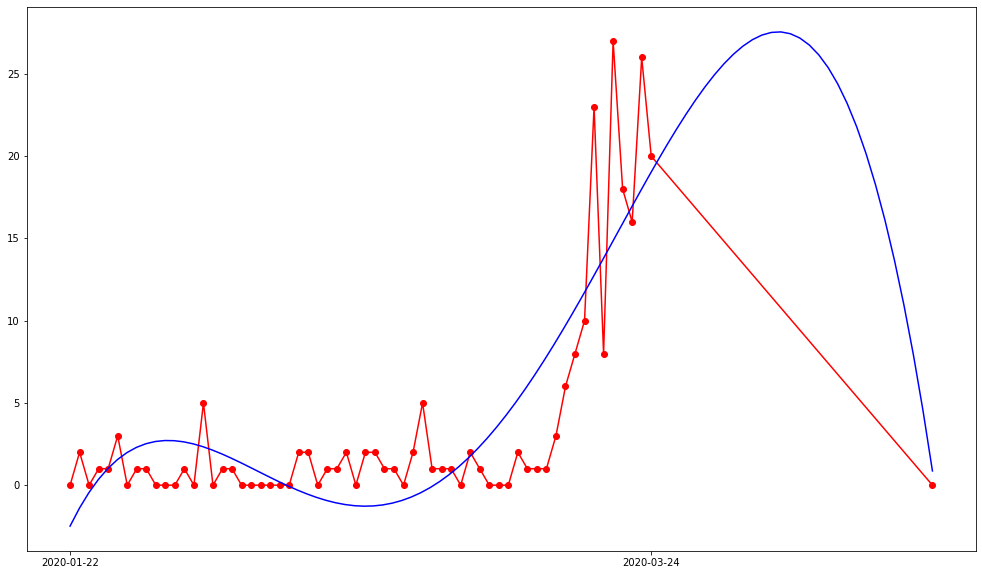

In [12]:
import pandas 
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

df = pandas.read_csv(dataPath)
dfTW = df.loc[df['Country/Region'] == 'Taiwan*']
V = np.flip(dfTW['Value'].to_numpy(dtype = 'int'))
V = np.diff(V)
Date = np.flip(dfTW['Date'].to_numpy())

n = 5 # the degee of polynomial
plus = 30
plusV = 0

#plus = 0
Ve = V
X1 = np.linspace(0.0, V.size, V.size)
if plus > 0:
    Ve = np.concatenate((Ve, np.array([plusV])))
    X1 = np.concatenate((X1, [V.size + plus]))
    
m = Ve.size
Xa = np.ones([m, n])
for i in range(1, n):
    Xa[:, i] = Xa[:, i - 1] * X1

R = np.linalg.lstsq(Xa, Ve, rcond = None)
A = np.array(R[0])

future = 30
m2 = V.size + future
X2 = np.linspace(0.0, m2, m2)
Xa = np.ones([m2, n])
for i in range(1, n):
    Xa[:, i] = Xa[:, i - 1] * X2
P = np.matmul(Xa, A)


plt.figure(figsize=(17,10))
plt.plot(X1, Ve, 'ro')
plt.plot(X1, Ve, linestyle='solid', color='red')
plt.plot(X2, P, linestyle='solid', color = 'blue')
plt.xticks([0, V.size], [Date[0], Date[-1]])
plt.show()
